Collins Kanyiri

## Business Problem

Our team of data scientists work together on a team for a new growing movie platform looking to compete with other giants such as Netflix, Hulu, and HBO. Our aim is to create a unique experience for each of our customers while subtly increasing our ROI. We aim to achieve this by building a tailored, unique recommendation system that can effectively suggest movies to our users, in order to continue to engage them with our platform. We want to be able to make predictions to our existing clients, as well as use our recommendation system as a product we use to attract new users to our platform. Additionally, as we continue to build up our recommendation systems, we plan to build our platform by investing in newer content for users to enjoy.

In [27]:
#Import relevant packages
import pandas as pd
import seaborn as sns
import numpy as np

from surprise import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV


import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
#Import the movies csv file 
movies = pd.read_csv('movies.csv')
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [29]:
#Import the ratings csv file 
ratings = pd.read_csv('ratings.csv')
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [30]:
tags = pd.read_csv('tags.csv')
tags.head(5)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [31]:
#Merge movies and ratings dataframes for easier reference.
df = pd.merge(ratings, movies, on='movieId', how='left').merge(tags, on = ['movieId', 'userId'], how = 'left')
df

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,NaN,NaN
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,NaN,NaN
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,NaN,NaN
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,NaN,NaN
...,...,...,...,...,...,...,...,...
102672,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller,NaN,NaN
102673,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller,Heroic Bloodshed,1.493844e+09
102674,610,168250,5.0,1494273047,Get Out (2017),Horror,NaN,NaN
102675,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,NaN,NaN


In [32]:
#df = df_MR.merge(tags, on = ['movieId', 'userId'], how = 'left')

In [33]:
#Add a feature 'year' that shows which year the movie is from 
df['year'] = df['title'].str.extract('.*\((.*)\).*',expand = False)
df.head(5)

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y,year
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN,1995
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,NaN,NaN,1995
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,NaN,NaN,1995
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,NaN,NaN,1995
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,NaN,NaN,1995


In [34]:
#Unique values in dataframe
df.nunique()

userId           610
movieId         9724
rating            10
timestamp_x    85043
title           9719
genres           951
tag             1543
timestamp_y     3219
year             107
dtype: int64

In [35]:
#Drop 'timestamp' as this column is unnecessary
data = df.drop(['timestamp_x', 'timestamp_y'], axis=1)

Before we continue, let us check on the sparsity of our matrix.

In [36]:
#Check sparsity of matrix
numratings = len(data['rating'])
numusers = len(data['userId'].unique())
numitems = len(data['movieId'].unique())

sparse = 1 - (numratings / (numusers*numitems))
sparse

0.9826899474681539

Our matrix is very sparse; 98%. We will now filter the data frame to deal with sparsity and create a denser utility matrix, by removing users who have provided a low number of ratings (less than 100) and movies that were rated less frequently (less than 10 times).

In [37]:
#Filter out users who have rated less than 200 movies 
data = data.groupby('userId').filter(lambda x: len(x)>100)

#Filter out movies who have rated less than 10 times 
data = data.groupby('movieId').filter(lambda x: len(x)>10)

recheck the sparsity of our matrix.


In [38]:
#Check sparsity of matrix
numratings = len(data['rating'])
numusers = len(data['userId'].unique())
numitems = len(data['movieId'].unique())

sparse = 1 - (numratings / (numusers*numitems))
sparse

0.8668616564214422

This result looks pretty good; our resulting matrix is much less sparse, at 79%

In [39]:
#Check for NA values 
data.isna().sum()

userId         0
movieId        0
rating         0
title          0
genres         0
tag        61963
year           0
dtype: int64

## EDA

In [40]:
# Look at 5 most populer movies that have been watched
Populer_Movies = data.groupby('title').size().sort_values(ascending=False)
Populer_Movies.head(5)

title
Pulp Fiction (1994)                          346
Fight Club (1999)                            192
Forrest Gump (1994)                          191
Matrix, The (1999)                           176
Star Wars: Episode IV - A New Hope (1977)    171
dtype: int64

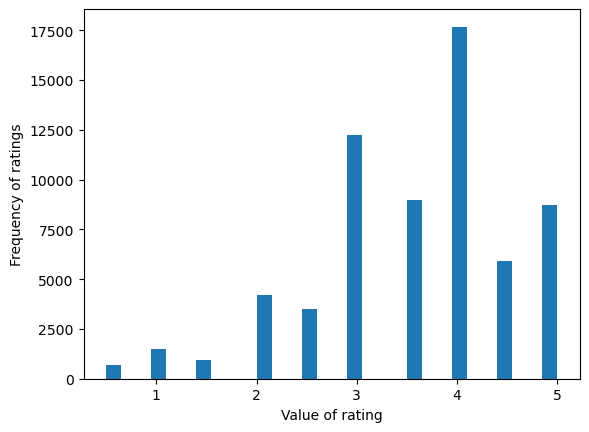

In [41]:
#Plot a histogram of the frequency of certain rating values
plt.hist(data['rating'],bins=30)
plt.xlabel('Value of rating')
plt.ylabel('Frequency of ratings')
plt.show()

#### genre

Interested to see how many unique genre combinations we have:

In [42]:
len(movies['genres'].unique())

951

So there are 951 unique genre combinations

In [43]:
count_genres = {}
for genre in movies['genres']:
    count_genres[genre] = count_genres.get(genre, 0) + 1


In [44]:
popular_genre = []
for genre in count_genres:
    if count_genres[genre] > 100:
        print(genre, count_genres[genre])
        popular_genre.append(genre)
print(len(popular_genre))

Comedy|Romance 363
Comedy|Drama|Romance 276
Comedy 946
Drama 1053
Crime|Drama 134
Drama|Romance 349
Drama|War 114
Drama|Thriller 168
Comedy|Crime 101
Comedy|Drama 435
Documentary 339
Crime|Drama|Thriller 125
Horror 167
Horror|Thriller 135
14


These are the top genre combinations

In [45]:
#Creat genre labels
genrelabels = set()
for i in data['genres'].str.split('|').values:
    genrelabels = genrelabels.union(set(i))

genrelabels  

{'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [46]:
#Create function that counts how many movies there are of each genre 
def genrecounts(df, col, labels):
    count = dict()
    for i in labels: count[i] = 0
    for value in df[col].str.split('|'):
        if type(value) == float and pd.isnull(value): continue
        for i in value: 
            if pd.notnull(i): count[i] += 1
    return count        


#Apply the genrecounts formula to our dataset and print the resulting genres and their counts 
genre_count = genrecounts(data, 'genres', genrelabels)
genre_count

{'Horror': 4205,
 'Animation': 4699,
 'Mystery': 5374,
 'IMAX': 3161,
 'Drama': 25893,
 'Musical': 2740,
 'Fantasy': 8484,
 'Children': 6199,
 'Documentary': 304,
 'Adventure': 17563,
 'Film-Noir': 614,
 'Action': 21964,
 'Romance': 11521,
 'Thriller': 18072,
 'Western': 1244,
 'Sci-Fi': 12934,
 'Crime': 11474,
 'Comedy': 25193,
 'War': 3112}

In [47]:
#Create a dataframe for the genres and their value counts 
genres = pd.DataFrame(list(genre_count.items()),columns = ['Genre','Frequency'])

#Sort the DataFrame
genres = genres.sort_values(by=['Frequency'], ascending=False)

#Print the resulting DataFrame 
genres

,Genre,Frequency
4,Drama,25893
17,Comedy,25193
11,Action,21964
13,Thriller,18072
9,Adventure,17563
15,Sci-Fi,12934
12,Romance,11521
16,Crime,11474
6,Fantasy,8484
7,Children,6199


# Observation



#### tags

In [48]:
count_tags = {}
for tag in tags['tag']:
    count_tags[tag] = count_tags.get(tag, 0) + 1



Let's look into the most common tags and find the top 20 tags.

In [49]:
popular_tag = []
for tag in count_tags:
    if count_tags[tag] > 0:
#         print(genre, count_genres[tag])
        popular_tag.append(tag)
print(len(popular_tag))

sorted_pop_tags = sorted(popular_tag, key=lambda x:x[1], reverse=True)

sorted_pop_tags[:20]

1589


['cyberpunk',
 'Mystery',
 'Ryan Reynolds',
 'dystopia',
 'ryan reynolds',
 'Dystopia',
 'system holism',
 'mystery',
 'cynical',
 'mythology',
 'Myth',
 'lyrical',
 'symbolism',
 'symbolic',
 'Exquisite plotting.',
 'ex-con',
 'existentialism',
 'Existential',
 'exciting',
 'twist ending']

We can see there's a lot of double ups here with tags that do and don't use capitilisation such asa 'Ryan Reynolds' vs. 'ryan reynolds'. As well as similar categories such as 'myth', 'mythology', even 'mystery'.
But since only a small set of the data is taged. we will drop the tag column

In [50]:
#Drop 'tag' column 
data = data.drop(['tag'], axis=1)
data

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,1995
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,1995
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995
...,...,...,...,...,...,...
102670,610,164179,5.0,Arrival (2016),Sci-Fi,2016
102671,610,166528,4.0,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi,2016
102673,610,168248,5.0,John Wick: Chapter Two (2017),Action|Crime|Thriller,2017
102674,610,168250,5.0,Get Out (2017),Horror,2017


#### users

In [51]:
#See which users have provided the most ratings
data['userId'].value_counts()

userId
599    1584
414    1498
474    1146
68     1044
448     951
       ... 
492      76
309      74
377      67
306      61
571      40
Name: count, Length: 246, dtype: int64

## observation

# Movie Recommendation System Models

In [52]:
#Create a new dataset with 'userId', 'movieId', 'rating'

df2 = df[['userId', 'movieId', 'rating']]
df2.head(5)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [53]:
#Instansiate reader and data 
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df2, reader)

In [54]:
#Train test split with test sizre of 20% 
trainset, testset = train_test_split(data, test_size=.2)

# Print number of uses and items for the trainset 
print('Number of users in train set : ', trainset.n_users, '\n')
print('Number of items in train set : ', trainset.n_items, '\n')

Number of users in train set :  610 

Number of items in train set :  8928 



### Baseline Model

baseline model will be a KNNBaseline model without any hyperparameters.

In [55]:
#Instansiate a baseline model using KNNBaseline 
baseline = KNNBaseline(random_state=42)

In [57]:
#Fit model on the trainset 
baseline.fit(trainset)

#Predict on the test set 
baselinepreds = baseline.test(testset)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [58]:
#Check RMSE and MAE results 
accuracy.rmse(baselinepreds)
accuracy.mae(baselinepreds)

RMSE: 0.8673
MAE:  0.6634


0.6634026370866156

The RMSE for our baseline is 0.8673 and the MAE is 0.6634. These are the values we will look to improve by attempting different models and including hyperparameters in future models. 

In [59]:
#Run 3-fold cross validation on the data and print results 
cv_baseline = cross_validate(baseline, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8814  0.8832  0.8734  0.8793  0.0043  
MAE (testset)     0.6727  0.6709  0.6667  0.6701  0.0025  
Fit time          0.81    0.83    1.05    0.90    0.11    
Test time         8.65    7.91    8.87    8.48    0.41    


In [60]:
# Print out the RMSE score for each fold 
for i in cv_baseline.items():
    print(i)

('test_rmse', array([0.88137747, 0.88318331, 0.87335298]))
('test_mae', array([0.67272002, 0.67086   , 0.66673477]))
('fit_time', (0.8073396682739258, 0.8336741924285889, 1.0474402904510498))
('test_time', (8.654839038848877, 7.909446954727173, 8.872887134552002))


In [ ]:
#Find the average test RMSE from the 3-Fold cross-validation
np.mean(cv_baseline['test_rmse'])

Our 3-fold cross validaiton has an average test RMSE of approximately 0.815. We will look to reduce this RMSE in future models.

### Model 1

Our first model will be an SVD Model using GridSearch. We will first apply GridSearch to idently the best parameters that reduce our RMSE, and then will re-instantiate our model with these parameters so we can then fit on the trainset and predict on the test set.

In [61]:
#Set parameters for GridSearch on SVD model 
parameters = {'n_factors': [20, 50, 80],
             'reg_all': [0.04, 0.06],
             'n_epochs': [10, 20, 30],
             'lr_all': [.002, .005, .01]}
gridsvd = GridSearchCV(SVD, param_grid=parameters, n_jobs=-1)

In [62]:
#Fit SVD model on data
gridsvd.fit(data)

#Print best score and best parameters from the GridSearch 
print(gridsvd.best_score)
print(gridsvd.best_params)

{'rmse': 0.8472858510301373, 'mae': 0.6457853908923827}
{'rmse': {'n_factors': 80, 'reg_all': 0.06, 'n_epochs': 30, 'lr_all': 0.01}, 'mae': {'n_factors': 80, 'reg_all': 0.06, 'n_epochs': 30, 'lr_all': 0.01}}


In [67]:
#Reinstantiate the model with the best parameters fromGridSearch 
Gridsvdtuned = SVD(n_factors=80,
               reg_all=0.06,
               n_epochs=30,
               lr_all=0.01)

#Fit and predict the model 
Gridsvdtuned.fit(trainset)
Gridsvdpreds = Gridsvdtuned.test(testset)

#Print RMSE and MAE results 
accuracy.rmse(Gridsvdpreds)
accuracy.mae(Gridsvdpreds)

RMSE: 0.8442
MAE:  0.6457


0.6456572439455847

Both our RMSE and MAE results are lower than in the baseline. Our SVD models are also improved because we have filtered out users and movies with lower ratings so that the sparsity of our matrix would decrease.

In [68]:
#Perform 3-Fold cross validation for SVD tuned model
cv_Gridsvd_tuned = cross_validate(Gridsvdtuned, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8587  0.8574  0.8541  0.8567  0.0019  
MAE (testset)     0.6561  0.6531  0.6507  0.6533  0.0022  
Fit time          1.62    2.43    2.08    2.04    0.33    
Test time         0.67    0.32    0.46    0.48    0.14    


In [69]:
#Display the results for all 3-folds 
for i in cv_Gridsvd_tuned.items():
    print(i)

('test_rmse', array([0.85868414, 0.85743876, 0.85409844]))
('test_mae', array([0.65606854, 0.65311373, 0.65072792]))
('fit_time', (1.6164205074310303, 2.4331469535827637, 2.0813775062561035))
('test_time', (0.6651363372802734, 0.3184020519256592, 0.4558274745941162))


In [70]:
# Print out the average RMSE score for the test set
np.mean(cv_Gridsvd_tuned['test_rmse'])

0.8567404453458193

Our 3-fold cross validation test RMSE result was approx. 0.8567; a slight decrease from our baseline model 3-fold cross validation of 0.8673.